In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import mutual_info_regression, r_regression
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error # with squared=False
from xgboost import XGBRegressor
import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('dark_background')
pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv('data/train_df.csv')
original_df = pd.read_csv('data/original_df.csv')
test_df = pd.read_csv('data/test_df.csv')
variables_table = pd.read_csv('data/variables_table.csv')

train_df = pd.get_dummies(train_df, columns=['Sex'], dtype=int)
original_df = pd.get_dummies(original_df, columns=['Sex'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['Sex'], dtype=int)

feature_columns = test_df.columns.to_list()
target_column = 'Rings'

variables_table

Variable Name     Role         Type                  Description  Units  \
0             Sex  Feature  Categorical         M, F, and I (infant)    NaN   
1          Length  Feature   Continuous    Longest shell measurement     mm   
2        Diameter  Feature   Continuous      perpendicular to length     mm   
3          Height  Feature   Continuous           with meat in shell     mm   
4    Whole_weight  Feature   Continuous                whole abalone  grams   
5  Shucked_weight  Feature   Continuous               weight of meat  grams   
6  Viscera_weight  Feature   Continuous  gut weight (after bleeding)  grams   
7    Shell_weight  Feature   Continuous            after being dried  grams   
8           Rings   Target      Integer  +1.5 gives the age in years    NaN   

  Missing Values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7             no  
8             no

### Functions

In [3]:
from joblib import Parallel, delayed
from sklearn import clone
from sklearn.model_selection import KFold


def make_mi(df):
    X = df.copy()
    y = X.pop(target_column)
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    return mi_scores

def make_r(df, standardize=True):
    X = df.copy()
    y = X.pop(target_column)
    if standardize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

    r_scores = r_regression(X_scaled, y)
    r_scores = pd.Series(r_scores, name='R Scores', index=X.columns).sort_values(ascending=False)
    return r_scores

def make_pi(df):
    X = df.copy()
    y = X.pop(target_column)
    model = XGBRegressor(n_jobs=4, random_state=1).fit(X, y)
    pi_scores = permutation_importance(estimator=model, X=X, y=y, n_repeats=10, n_jobs=-1)
    pi_scores = pd.DataFrame({'Mean': pi_scores.importances_mean, 'Std':pi_scores.importances_std},
                             index=X.columns).sort_values(by='Mean', ascending=False)
    return pi_scores

def make_pdp(df, column, model=XGBRegressor(objective='reg:squarederror', random_state=0)):
    X = df.copy()
    y = X.pop(target_column)

    X_train, X_test, y_train, _ = train_test_split(X, y, random_state=1)
    model = model.fit(X_train, y_train)

    disp = PartialDependenceDisplay.from_estimator(model, X_test, [column])
    plt.show()
    
def xgb_importances(df, model=XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=0)):
    X = df.copy()
    y = X.pop(target_column)
    column_list = X.columns.to_list()
    model = XGBRegressor(objective='reg:squarederror', random_state=0, n_jobs=-1)
    model.fit(X, y)
    importances = model.feature_importances_
    series = pd.Series(importances, name='Importances', index=[column_list[i] for i in range(0, importances.size)]).sort_values(ascending=False)
    return series
    
def get_shap(df, row, model=XGBRegressor(objective='reg:squarederror', random_state=0)):
    X = df.copy()
    y = X.pop(target_column)
        
    X_train, X_valid, y_train, _ = train_test_split(X, y, random_state=1)
    model = model.fit(X_train, y_train)
        
    data_for_pred = X_valid.iloc[row].values

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data_for_pred.reshape(1, -1))
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values[0, :], data_for_pred, feature_names=X.columns, link="identity")

def get_shap2(df, row, model=XGBRegressor(objective='reg:squarederror', random_state=0)):
    X = df.copy()
    y = X.pop(target_column)
        
    X_train, X_valid, y_train, _ = train_test_split(X, y, stratify=y, random_state=1)
    model = model.fit(X_train, y_train)

    data_point = X_valid.iloc[row].values

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data_point.reshape(1, -1))

    return shap.waterfall_plot(shap.Explanation(values=shap_values[0, :], 
                                                base_values=explainer.expected_value, 
                                                feature_names=X_valid.columns.to_list()),
                                                max_display=10)

def apply_pca(X, standardize=True):
    X = X.copy()
    columns = X.columns
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=component_names,
        index=columns,
    )
    return pca, X_pca, loadings

def plot_variance(pca):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    fig.set(figwidth=10, dpi=300)
    return axs

def crossval(df, estimator=XGBRegressor(objective='reg:squarederror', random_state=0)):
    X = df.copy()
    y = X.pop(target_column)
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    
    def evaluate_fold(train_idx, test_idx):
        model = clone(estimator)
        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        X_test = X.iloc[test_idx].reset_index(drop=True)
        y_test = y.iloc[test_idx].reset_index(drop=True)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmsle_score = mean_squared_log_error(y_test, y_pred, squared=False)
        return rmsle_score
    
    results = Parallel(n_jobs=-1)(delayed(evaluate_fold)(train_idx, test_idx) for train_idx, test_idx in kf.split(y))
    baseline = 0.150147
    rmsle_mean = np.mean(results)
    rmsle_std = np.std(results)
    metrics_dict = {
        'RMSLE mean': rmsle_mean,
        'RMSLE std': rmsle_std,
        'Relative Improvement (%)': (rmsle_mean - baseline)*100/baseline
    }
    return pd.DataFrame(metrics_dict, index=[''])

### Distributions

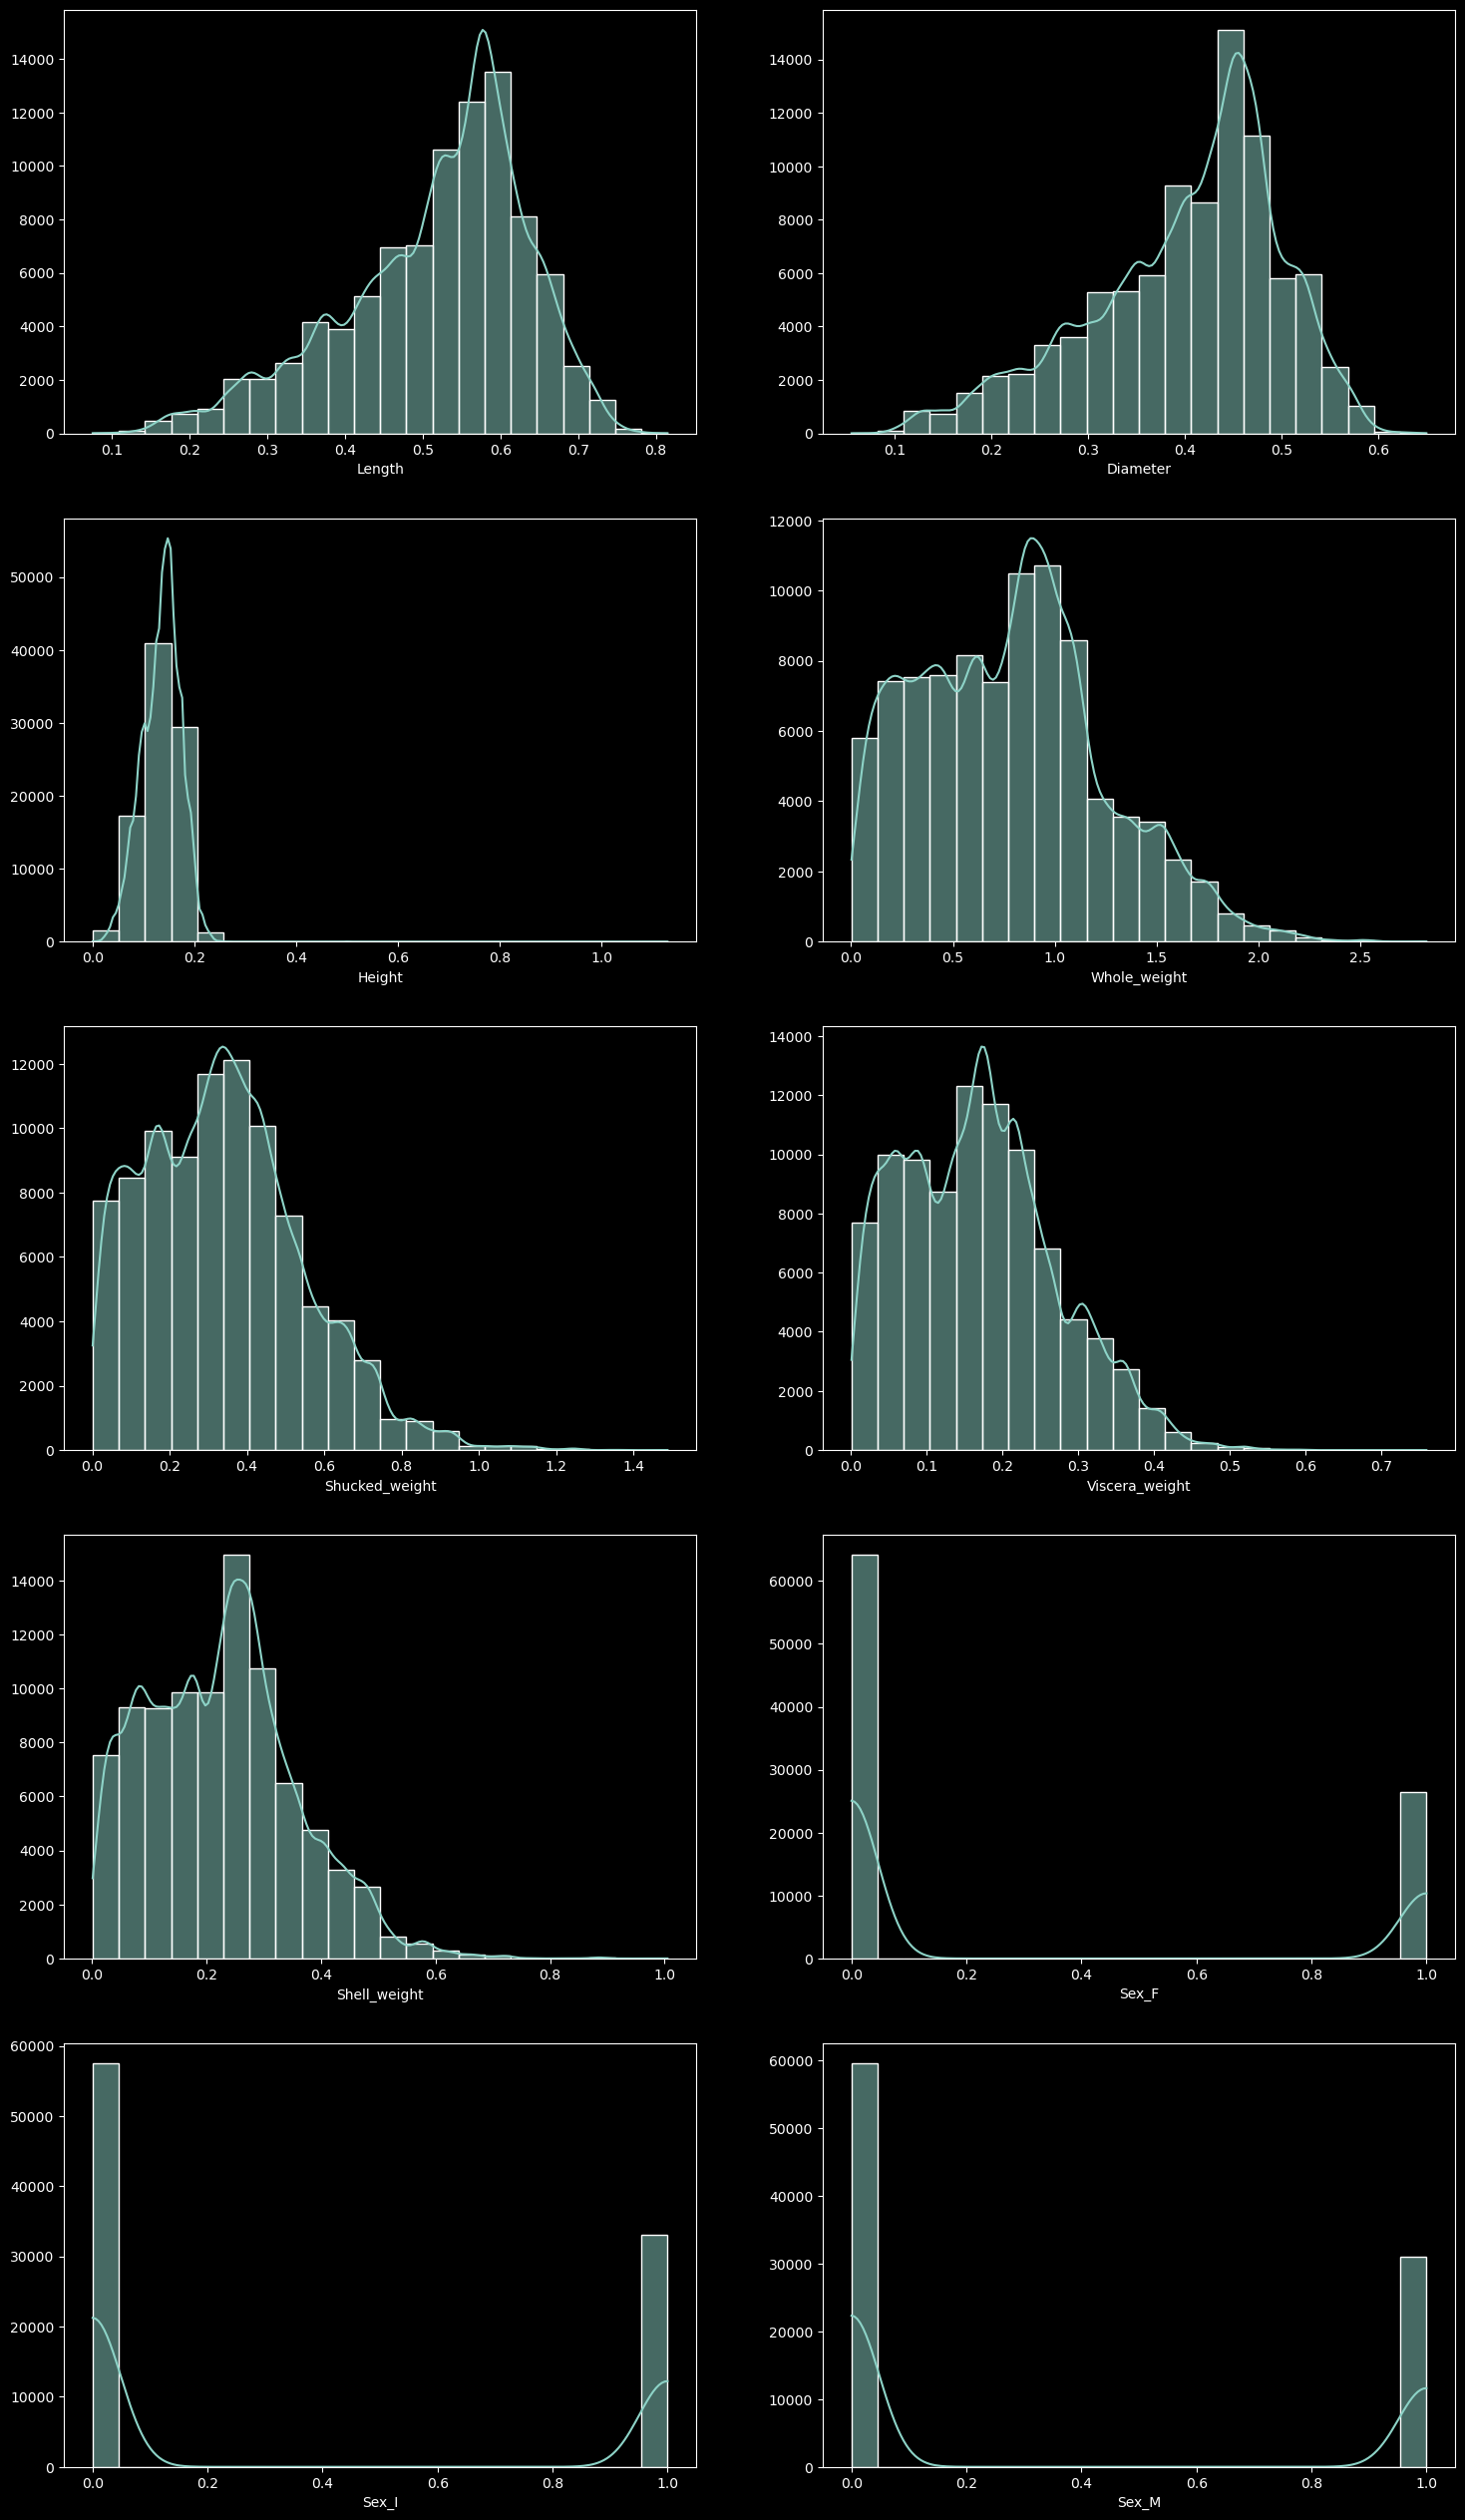

In [4]:
rows, cols = 5, 2
fig, axs = plt.subplots(rows, cols, figsize=(18,32))
for idx, col in enumerate(feature_columns):
    sns.histplot(train_df[col], kde=True, bins=22, ax=axs[idx//cols, idx%cols])
    axs[idx//cols, idx%cols].set_ylabel('')

plt.show()

In [5]:
for col in feature_columns[:-3]:
    print(f'Column: {col:<14} | Skewness: {train_df[col].skew():<7.4f} | Kurtosis: {train_df[col].kurt():.4f}')

Column: Length         | Skewness: -0.7320 | Kurtosis: 0.1334
Column: Diameter       | Skewness: -0.6952 | Kurtosis: 0.0006
Column: Height         | Skewness: 0.3100  | Kurtosis: 13.4541
Column: Whole_weight   | Skewness: 0.4293  | Kurtosis: -0.1851
Column: Shucked_weight | Skewness: 0.5920  | Kurtosis: 0.2840
Column: Viscera_weight | Skewness: 0.4767  | Kurtosis: -0.2037
Column: Shell_weight   | Skewness: 0.4791  | Kurtosis: 0.0960


- `Length` and `Diameter` are slightly left-skewed. I would try to transform them only for specific models.
- `Height` is leptokurtic or might have some outliers.
- `Weight` columns could be binned to see if it improves a model.

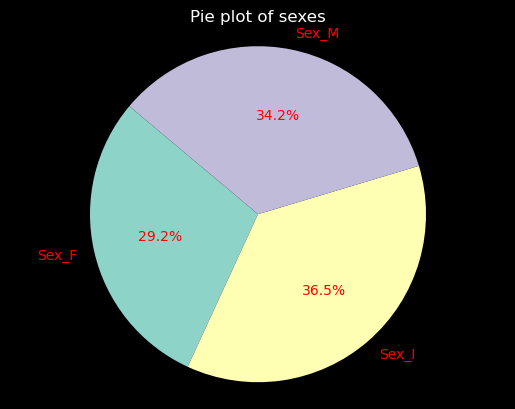

In [6]:
plt.pie(counts := train_df[['Sex_F', 'Sex_I', 'Sex_M']].sum(), labels=counts.index, 
        autopct='%1.1f%%', textprops={'color': 'red'}, startangle=140)
plt.title('Pie plot of sexes')
plt.axis('equal')
plt.show()

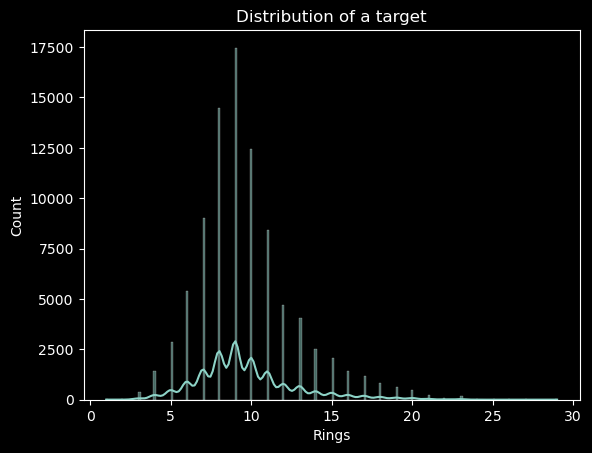

In [7]:
sns.histplot(train_df[target_column], kde=True)
plt.title('Distribution of a target')
plt.show()

### Correlations

In [8]:
train_df.corr()

Length  Diameter    Height  Whole_weight  Shucked_weight  \
Length          1.000000  0.989732  0.916094      0.931449        0.909609   
Diameter        0.989732  1.000000  0.919618      0.933848        0.908466   
Height          0.916094  0.919618  1.000000      0.902344        0.861769   
Whole_weight    0.931449  0.933848  0.902344      1.000000        0.971249   
Shucked_weight  0.909609  0.908466  0.861769      0.971249        1.000000   
Viscera_weight  0.913134  0.914668  0.886132      0.974319        0.949227   
Shell_weight    0.911073  0.917871  0.904019      0.964201        0.911800   
Rings           0.623786  0.636832  0.665772      0.617274        0.515067   
Sex_F           0.365578  0.370765  0.367521      0.368940        0.343068   
Sex_I          -0.656415 -0.664771 -0.645291     -0.651185       -0.619272   
Sex_M           0.315624  0.319131  0.302475      0.307096        0.299513   

                Viscera_weight  Shell_weight     Rings     Sex_F     Sex_I  \
Length                0.913134      0.911073  0.623786  0.365578 -0.656415   
Diameter              0.914668      0.917871  0.636832  0.370765 -0.664771   
Height                0.886132      0.904019  0.665772  0.367521 -0.645291   
Whole_weight          0.974319      0.964201  0.617274  0.368940 -0.651185   
Shucked_weight        0.949227      0.911800  0.515067  0.343068 -0.619272   
Viscera_weight        1.000000      0.937069  0.588954  0.370807 -0.646484   
Shell_weight          0.937069      1.000000  0.694766  0.372127 -0.648101   
Rings                 0.588954      0.694766  1.000000  0.296411 -0.516591   
Sex_F                 0.370807      0.372127  0.296411  1.000000 -0.487569   
Sex_I                -0.646484     -0.648101 -0.516591 -0.487569  1.000000   
Sex_M                 0.300536      0.300911  0.240048 -0.463848 -0.547320   

                   Sex_M  
Length          0.315624  
Diameter        0.319131  
Height          0.302475  
Whole_weight    0.307096  
Shucked_weight  0.299513  
Viscera_weight  0.300536  
Shell_weight    0.300911  
Rings           0.240048  
Sex_F          -0.463848  
Sex_I          -0.547320  
Sex_M           1.000000

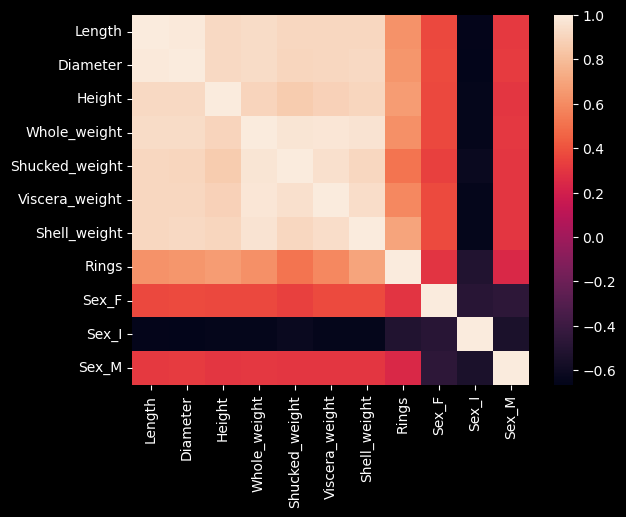

In [9]:
sns.heatmap(data=train_df.corr());

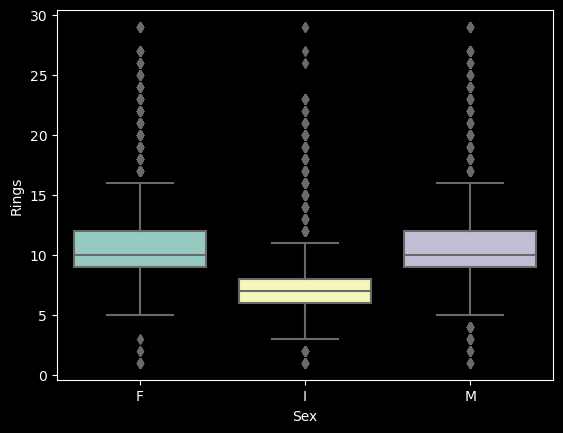

In [10]:
df = pd.read_csv('data/train_df.csv')
sns.boxplot(data=df, x='Sex', y='Rings');

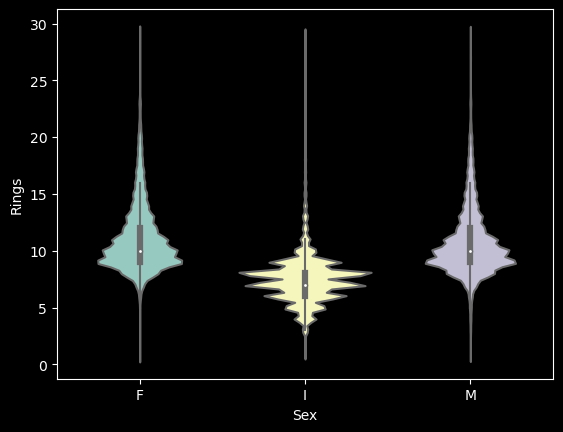

In [11]:
sns.violinplot(data=df, x='Sex', y='Rings');

In [12]:
df.groupby('Sex').describe(percentiles=[0.50])

Length                                          Diameter            \
       count      mean       std    min    50%    max    count      mean   
Sex                                                                        
F    26495.0  0.584330  0.071348  0.230  0.585  0.815  26495.0  0.458219   
I    33093.0  0.414792  0.104592  0.075  0.425  0.770  33093.0  0.315766   
M    31027.0  0.568806  0.084280  0.090  0.575  0.815  31027.0  0.445032   

                                     Height                                   \
          std    min    50%    max    count      mean       std   min    50%   
Sex                                                                            
F    0.059050  0.130  0.460  0.635  26495.0  0.157194  0.027658  0.05  0.155   
I    0.085249  0.055  0.325  0.600  33093.0  0.103129  0.029335  0.00  0.100   
M    0.069665  0.090  0.450  0.650  31027.0  0.151396  0.029591  0.00  0.150   

          Whole_weight                                              \
      max        count      mean       std     min     50%     max   
Sex                                                                  
F    1.13      26495.0  1.051711  0.377650  0.0340  1.0070  2.8255   
I    0.23      33093.0  0.396115  0.261157  0.0020  0.3565  2.7795   
M    1.13      31027.0  0.983810  0.394574  0.0095  0.9555  2.8255   

    Shucked_weight                                             Viscera_weight  \
             count      mean       std     min     50%     max          count   
Sex                                                                             
F          26495.0  0.449880  0.175309  0.0145  0.4305  1.2695        26495.0   
I          33093.0  0.173873  0.117814  0.0010  0.1575  1.1455        33093.0   
M          31027.0  0.425631  0.184193  0.0035  0.4070  1.4880        31027.0   

                                               Shell_weight            \
         mean       std     min     50%    max        count      mean   
Sex                                                                     
F    0.227631  0.084946  0.0080  0.2175  0.590      26495.0  0.301273   
I    0.083415  0.056068  0.0005  0.0735  0.548      33093.0  0.114645   
M    0.211449  0.087605  0.0015  0.2035  0.760      31027.0  0.280194   

                                       Rings                                  \
          std     min    50%    max    count       mean       std  min   50%   
Sex                                                                            
F    0.107665  0.0090  0.287  0.897  26495.0  11.161389  3.021624  1.0  10.0   
I    0.075507  0.0015  0.100  0.885  33093.0   7.533557  2.131495  1.0   7.0   
M    0.111943  0.0015  0.270  1.005  31027.0  10.753408  2.980265  1.0  10.0   

           
      max  
Sex        
F    29.0  
I    29.0  
M    29.0

Seems like the biggest variance is between being an Infant, or not

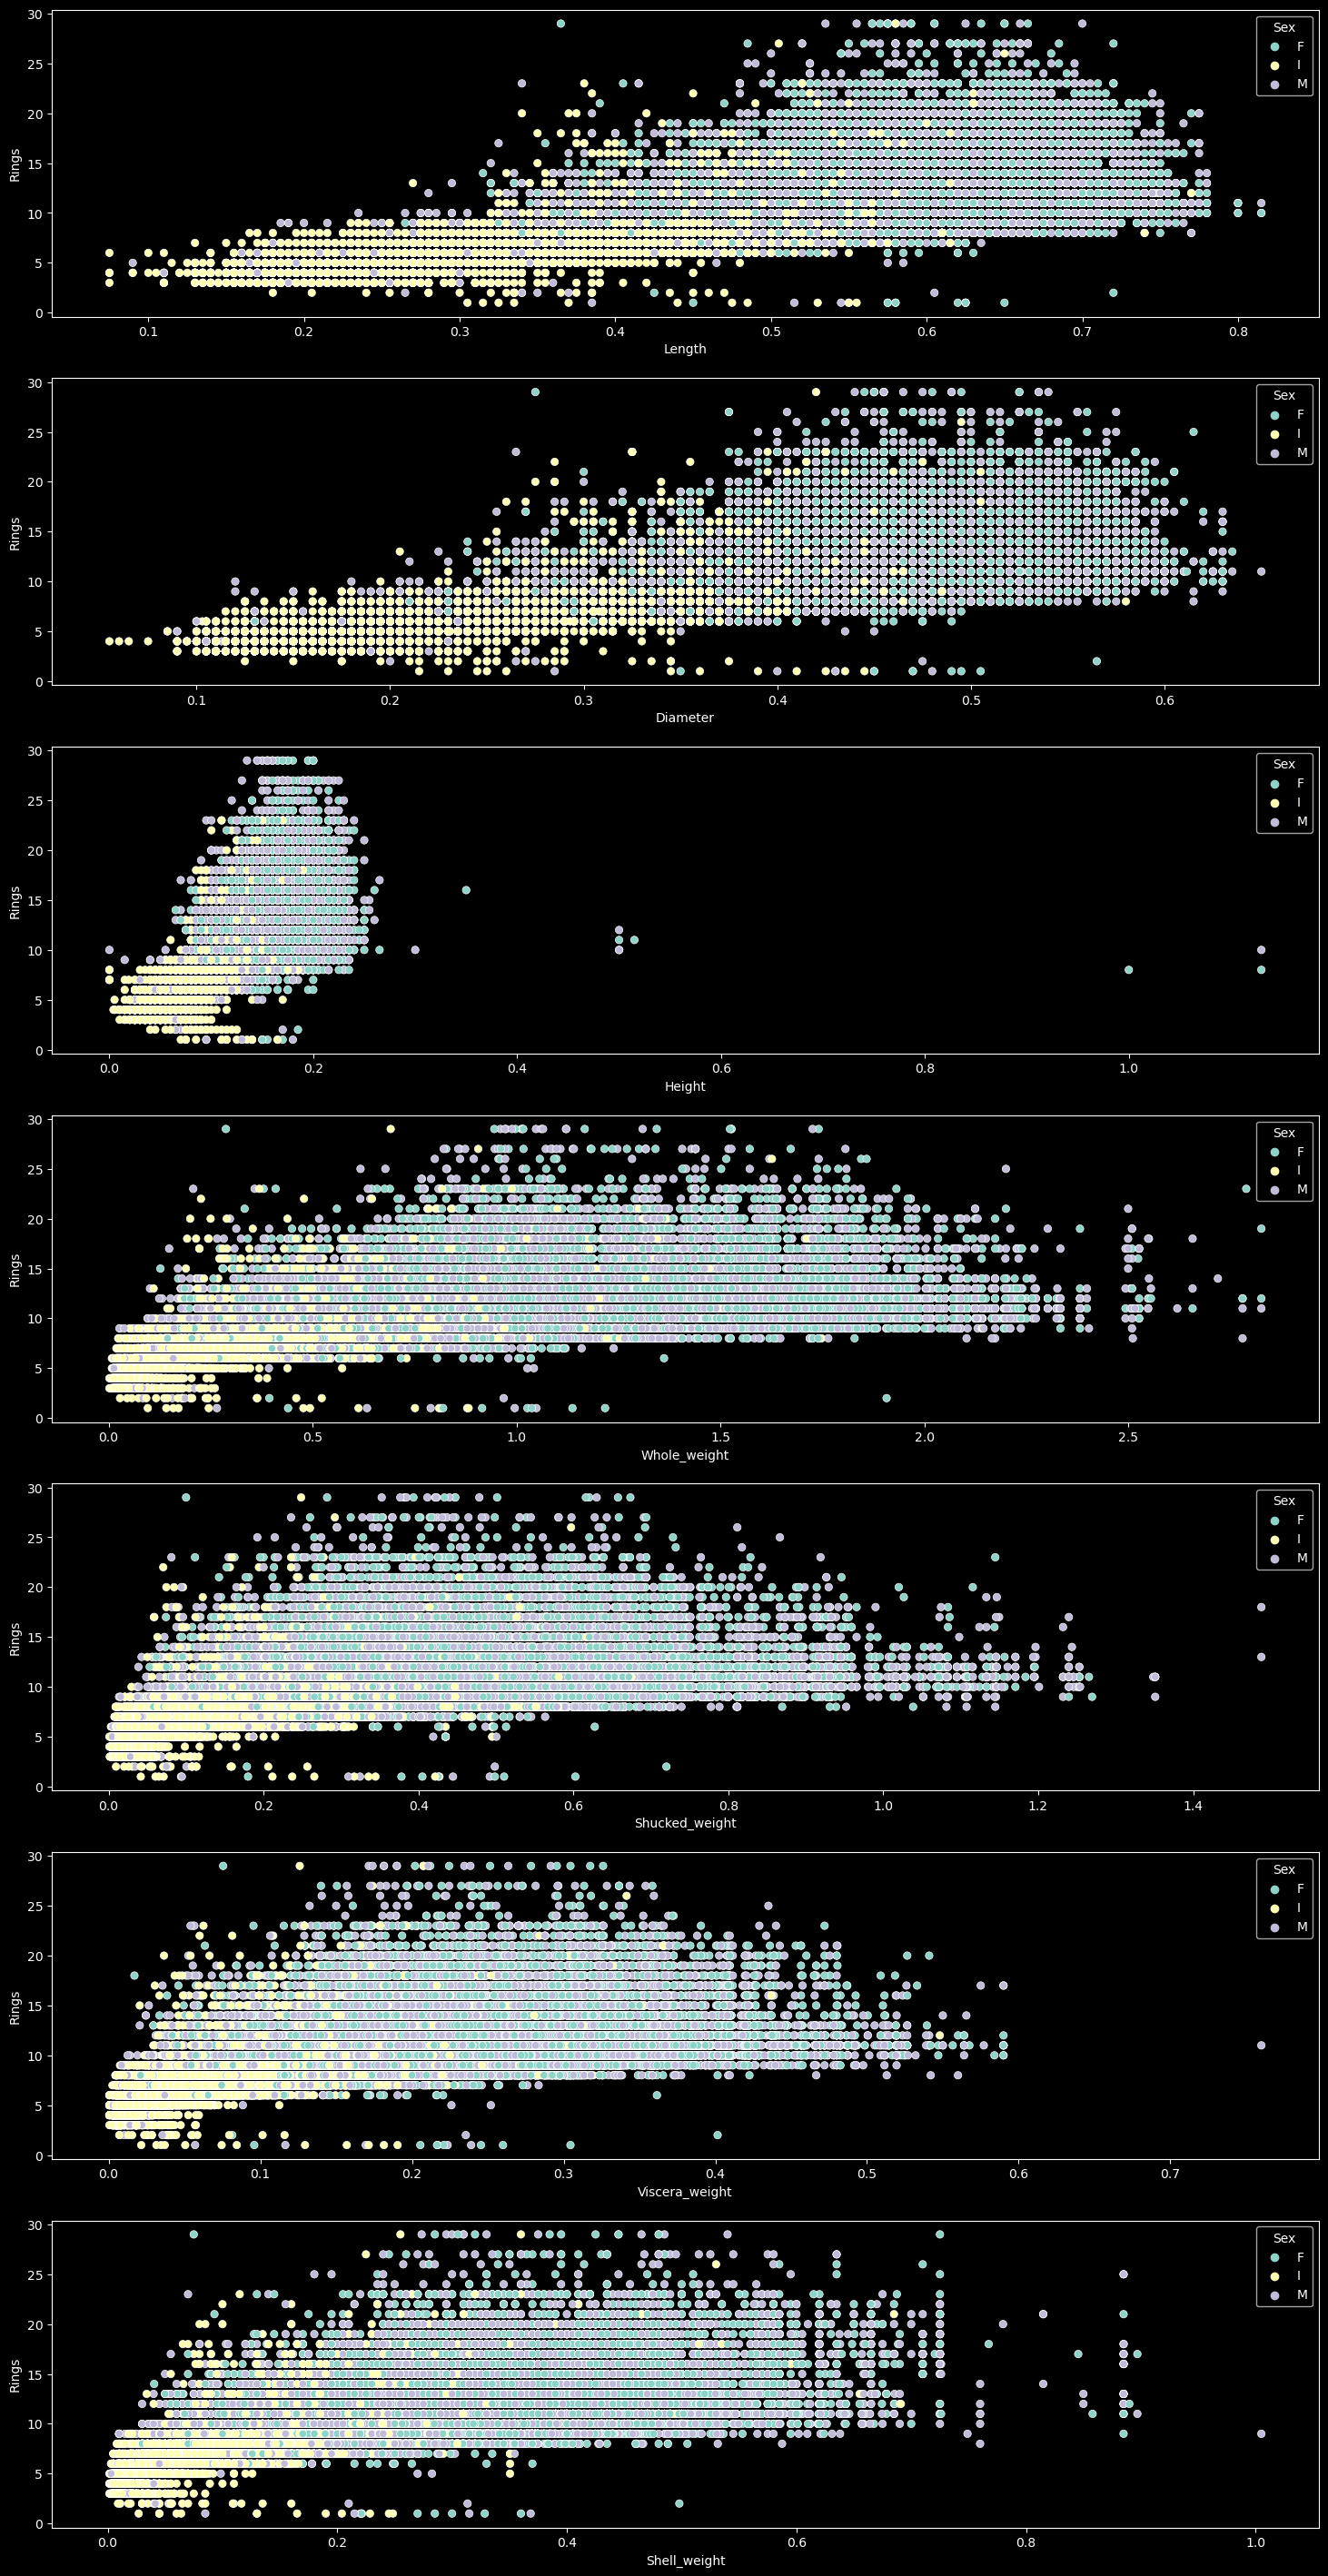

In [13]:
fig, axs = plt.subplots(7, 1, figsize=(18, 36))
for idx, col in enumerate(df.columns.to_list()[1:-1]):
    sns.scatterplot(data=df, x=col, y='Rings', hue='Sex', ax=axs[idx])
    
plt.show()

- 9 clear outliers in `Height`, that strongly modified kurtosis.
- In other columns there are only a few outliers, might be the same samples as in the point above

In [14]:
make_r(train_df)

Shell_weight      0.694766
Height            0.665772
Diameter          0.636832
Length            0.623786
Whole_weight      0.617274
Viscera_weight    0.588954
Shucked_weight    0.515067
Sex_F             0.296411
Sex_M             0.240048
Sex_I            -0.516591
Name: R Scores, dtype: float64

### Outliers/Anomalies

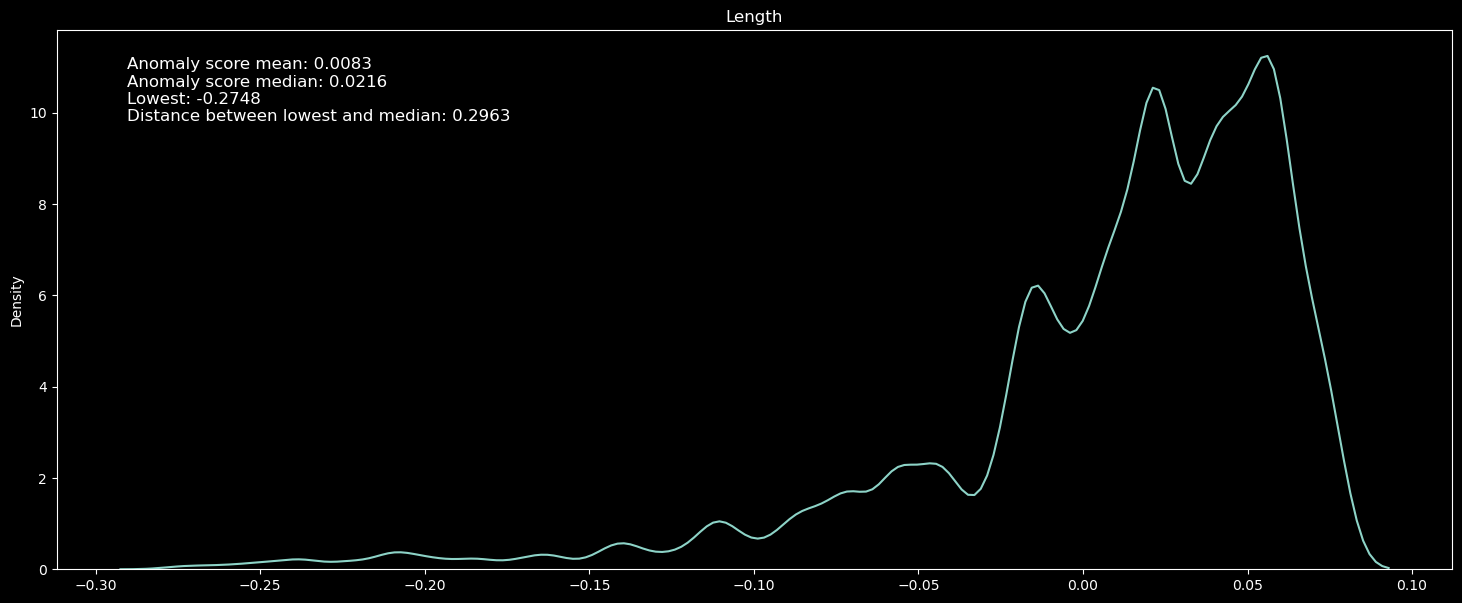

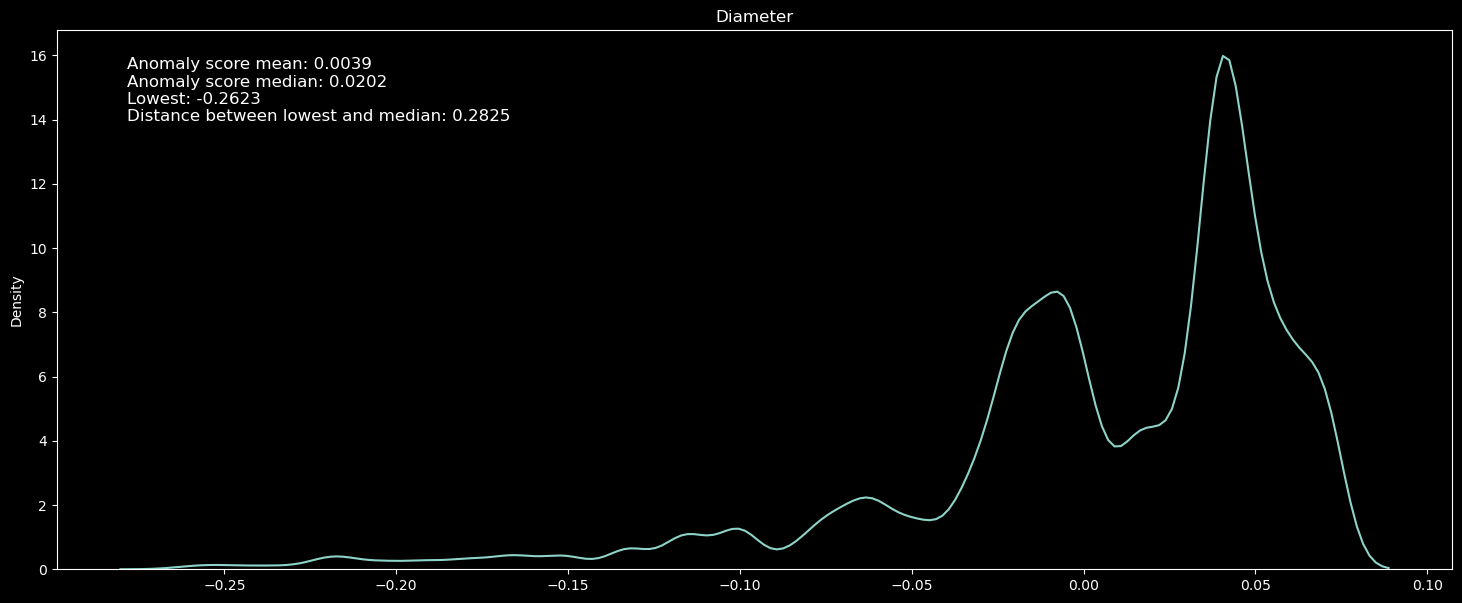

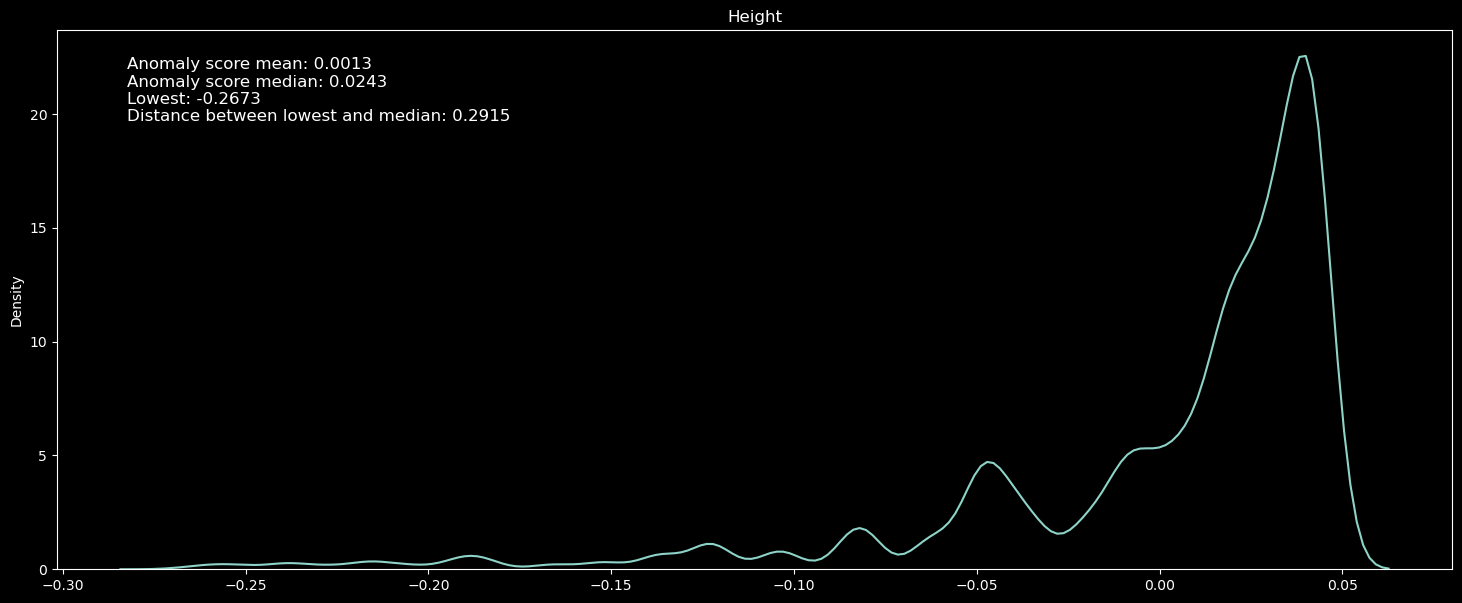

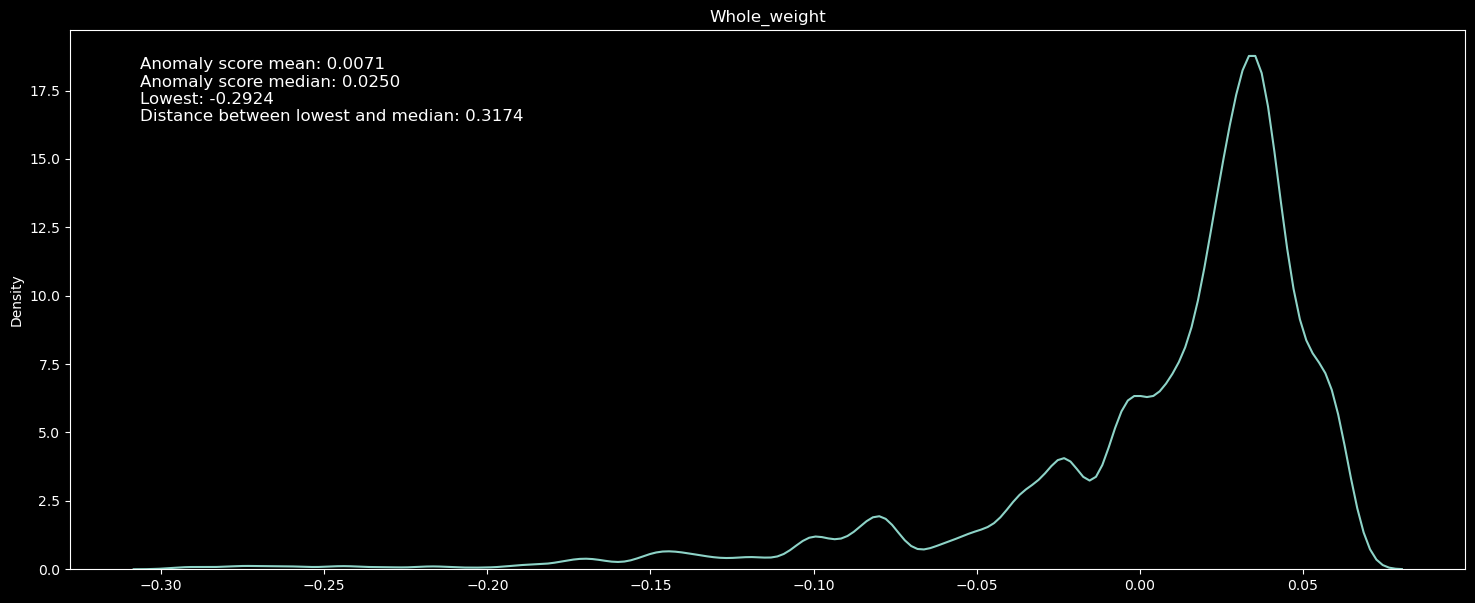

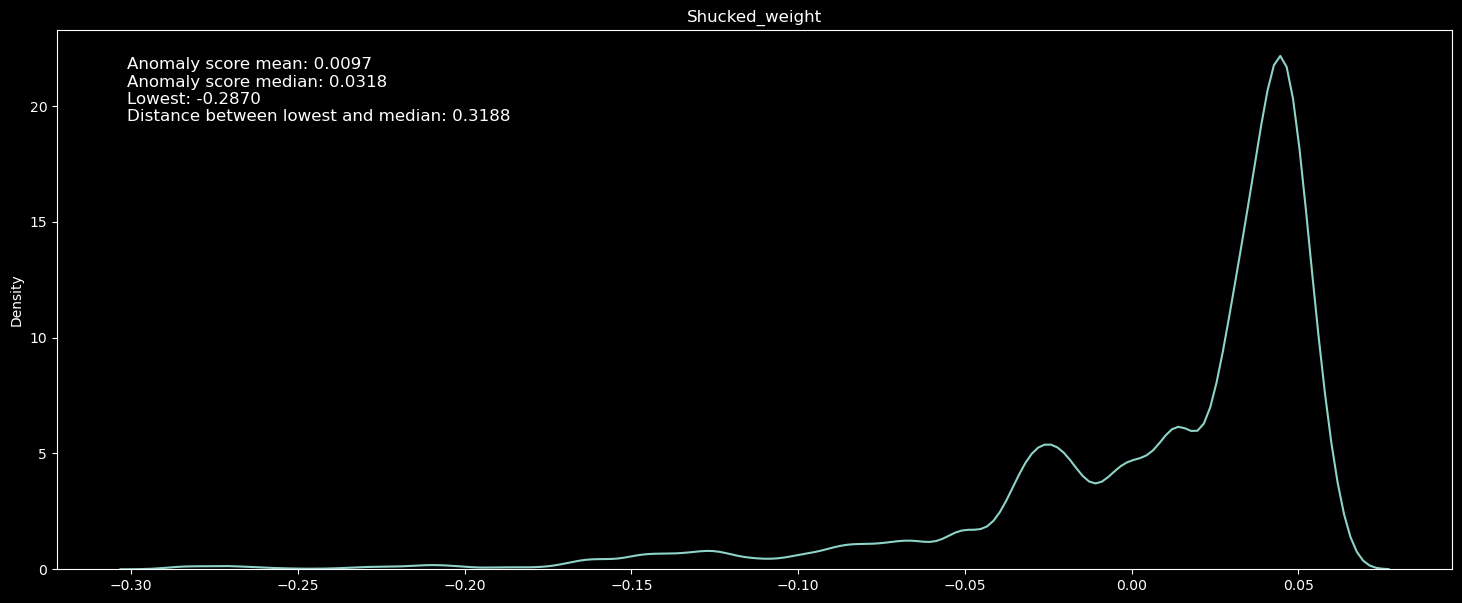

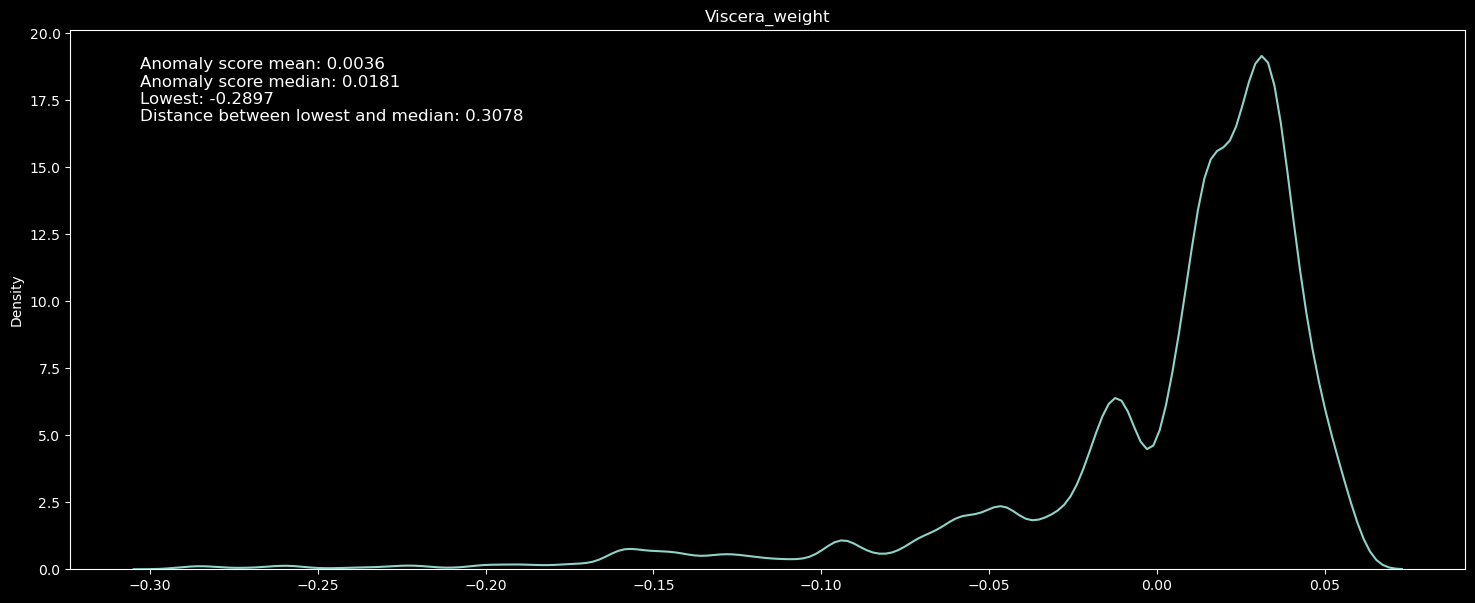

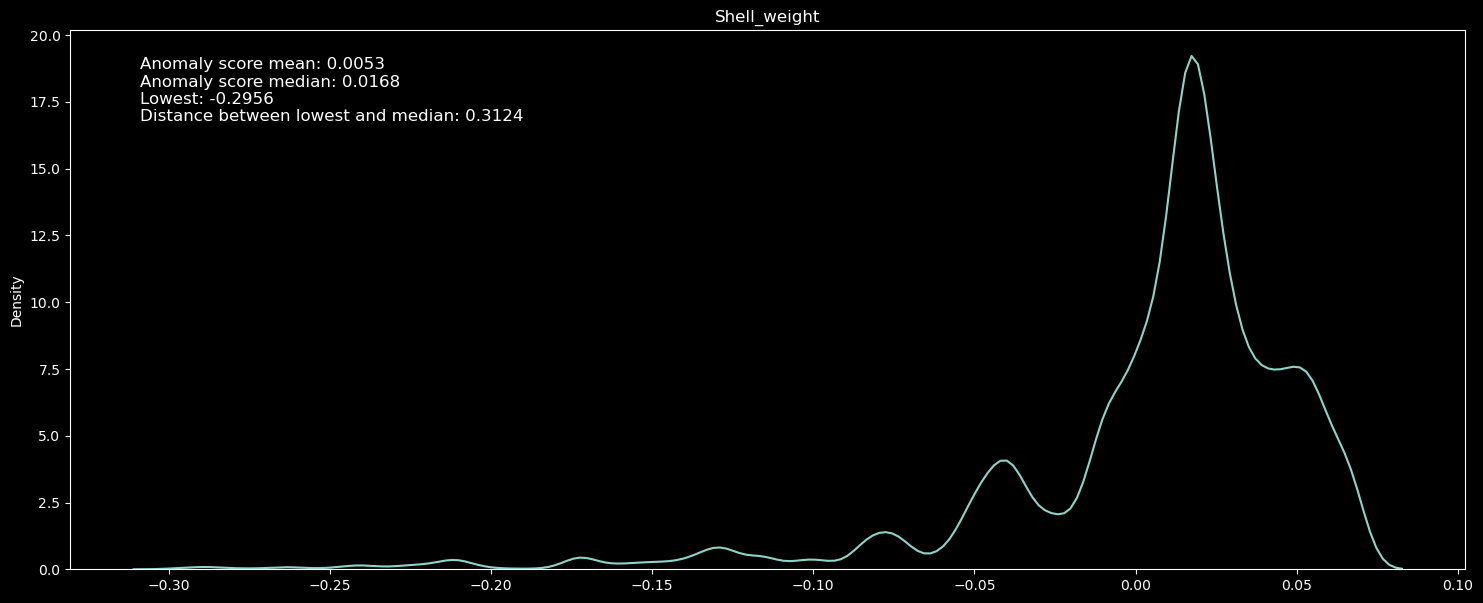

In [15]:
from sklearn.ensemble import IsolationForest

for col in feature_columns[:-3]:
    X = train_df[col].values.reshape(-1, 1)
    iso_forest = IsolationForest(random_state=1).fit(X)
    anomaly_score = iso_forest.decision_function(X)
    plt.figure(figsize=(18, 7))
    sns.kdeplot(anomaly_score)
    plt.title(col)
    inside_text = f'Anomaly score mean: {np.mean(anomaly_score):.4f}\nAnomaly score median: {np.median(anomaly_score):.4f}\n'+ \
        f'Lowest: {np.min(anomaly_score):.4f}\nDistance between lowest and median: {np.abs(np.min(anomaly_score) - np.median(anomaly_score)):.4f}'
    plt.text(0.05, 0.95, inside_text,
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0))
    plt.show()

In [16]:
indices = np.where(train_df['Height'] > 0.3)
for col in feature_columns[:-3]:
    X = train_df[col].values.reshape(-1, 1)
    iso_forest = IsolationForest(random_state=1).fit(X)
    anomaly_score = iso_forest.decision_function(X)
    anomaly_score = anomaly_score[indices]
    print(f'Column: {col}')
    print(anomaly_score)
    print('-'*40)

Column: Length
[ 0.05246211 -0.02117005 -0.01821007 -0.22415328 -0.10103651 -0.004732
 -0.00426614  0.04984372  0.0574946 ]
----------------------------------------
Column: Diameter
[ 0.02807699 -0.0030262  -0.06587572 -0.06868562 -0.16630346 -0.00763316
  0.00108753  0.07077875  0.05993038]
----------------------------------------
Column: Height
[-0.26055914 -0.25953066 -0.25799056 -0.25953066 -0.25953066 -0.25953066
 -0.25953066 -0.26055914 -0.26055914]
----------------------------------------
Column: Whole_weight
[ 3.15757618e-02 -1.29928776e-01  4.70800444e-05 -1.33046136e-01
 -2.73180216e-01  3.56166404e-04 -4.36891623e-03  3.28889059e-02
  4.86704031e-02]
----------------------------------------
Column: Shucked_weight
[ 0.03649108  0.00245155 -0.00642651 -0.13613721 -0.27538434 -0.00471668
  0.01503449  0.01492365  0.01224972]
----------------------------------------
Column: Viscera_weight
[ 0.03463712 -0.04312536  0.02760056 -0.14465566 -0.26900654 -0.00997495
 -0.00997495  0.02

Looks like samples that have extreme values of `Height` also are usually classified as anomalies in other columns.

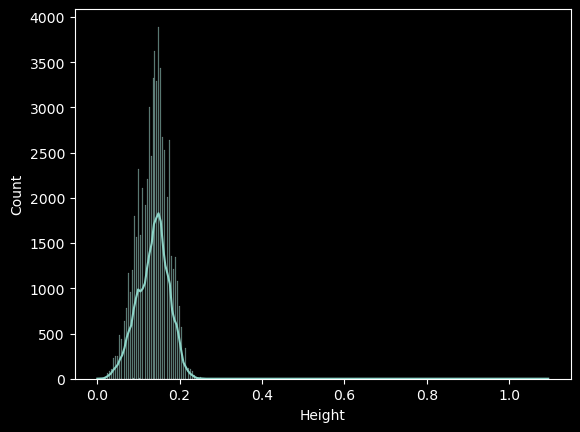

In [17]:
sns.histplot(test_df['Height'], kde=True);

In [18]:
test_df.iloc[np.where(test_df['Height'] > 0.3)]

Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
4338    0.750     0.565   0.515        2.1055          1.0200          0.4465   
6212    0.370     0.290   0.600        0.2825          0.0935          0.0575   
6846    0.475     0.360   1.095        0.4155          0.1780          0.0905   
7231    0.665     0.515   1.005        1.0455          0.6430          0.2355   
24105   0.575     0.460   0.375        0.9575          0.4435          0.2325   
49825   0.625     0.480   0.350        1.2655          0.6025          0.3075   
51380   0.435     0.335   1.065        0.3625          0.1340          0.0830   
56003   0.625     0.480   0.650        1.3475          0.5450          0.2565   
58424   0.725     0.590   0.495        2.2385          0.7640          0.4200   

       Shell_weight  Sex_F  Sex_I  Sex_M  
4338         0.5080      0      0      1  
6212         0.0815      0      0      1  
6846         0.1365      0      1      0  
7231         0.3490      0      1      0  
24105        0.2900      1      0      0  
49825        0.3150      1      0      0  
51380        0.1175      0      1      0  
56003        0.4750      1      0      0  
58424        0.5850      1      0      0

In [19]:
train_df.iloc[np.where(train_df['Height'] > 0.3)]

Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
16384   0.515     0.375   1.130        0.5720          0.2370          0.1455   
28651   0.665     0.515   0.500        1.7825          0.5330          0.3340   
54423   0.660     0.540   0.350        1.2635          0.5595          0.2435   
55852   0.745     0.545   0.500        1.7875          0.8075          0.3935   
56089   0.705     0.575   0.515        2.2100          1.1075          0.4865   
58048   0.635     0.495   0.500        1.2615          0.5385          0.3050   
63851   0.640     0.510   0.500        1.3715          0.5065          0.3050   
65464   0.585     0.450   1.130        1.1000          0.5085          0.2425   
77326   0.565     0.455   1.000        1.0145          0.5255          0.2440   

       Shell_weight  Rings  Sex_F  Sex_I  Sex_M  
16384        0.1500      8      1      0      0  
28651        0.4285     10      1      0      0  
54423        0.4150     16      1      0      0  
55852        0.5650     10      0      0      1  
56089        0.5120     11      1      0      0  
58048        0.3750     11      1      0      0  
63851        0.4700     12      0      0      1  
65464        0.2800     10      0      0      1  
77326        0.2835      8      1      0      0

Test dataset also has 9 extreme values for `Height`. Some of the options are:
1. Leave those values in both datasets
2. Winsorize them
3. Drop them in training set and assume that generative neural networks, used for this competition, created not so reliable data with desired distribution. Also the train/test split seem not random. To predict those values in test dataset I would train another model for this task, without `Height` column

In [20]:
#from sklearn.cluster import DBSCAN

#scan_X = train_df.copy()[feature_columns]
#dbscan = DBSCAN(eps=1, min_samples=5, n_jobs=-1)
#dbscan.fit(scan_X)
#indices = dbscan.labels_ == -1
#train_df.iloc[indices]

Another way to check for outliers, but in a feature space [heavy on memory]

### Feature importances

In [21]:
# Mutual information
baseline_mi = make_mi(train_df)
baseline_mi

Shell_weight      0.673388
Whole_weight      0.573460
Height            0.551503
Diameter          0.544858
Viscera_weight    0.542937
Length            0.536784
Shucked_weight    0.511368
Sex_I             0.235966
Sex_F             0.082582
Sex_M             0.062428
Name: MI Scores, dtype: float64

In [22]:
# Permutation importance
baseline_pi = make_pi(train_df)
baseline_pi

Mean       Std
Whole_weight    1.690079  0.008599
Shucked_weight  1.276458  0.006788
Shell_weight    1.127519  0.005361
Viscera_weight  0.567687  0.002722
Height          0.296315  0.002518
Diameter        0.153345  0.001244
Length          0.076474  0.000788
Sex_I           0.014074  0.000225
Sex_F           0.002069  0.000115
Sex_M           0.000657  0.000060

In [23]:
baseline_importances = xgb_importances(train_df)
baseline_importances

Shell_weight      0.628711
Sex_I             0.110258
Shucked_weight    0.102309
Height            0.039575
Whole_weight      0.033282
Viscera_weight    0.020816
Length            0.019795
Diameter          0.016945
Sex_F             0.014888
Sex_M             0.013421
Name: Importances, dtype: float32

`Sex_F` and `Sex_M` does not help in this regression very much. Cosidering transforming whole Sex column into: Is Infant, isn't 

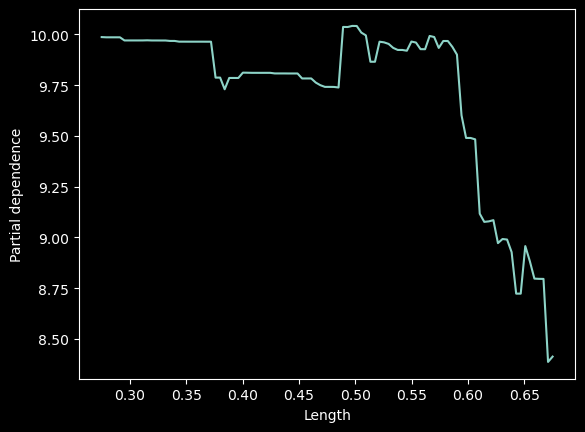

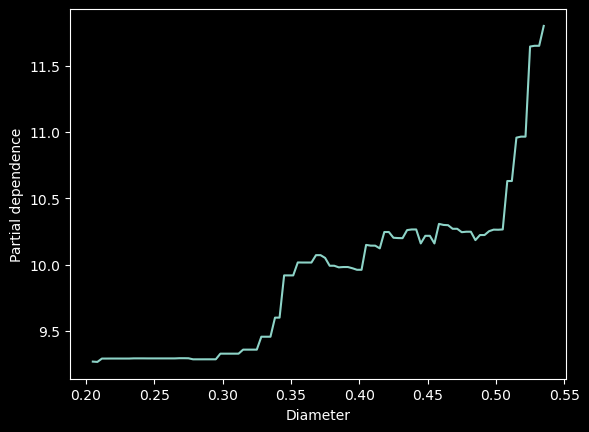

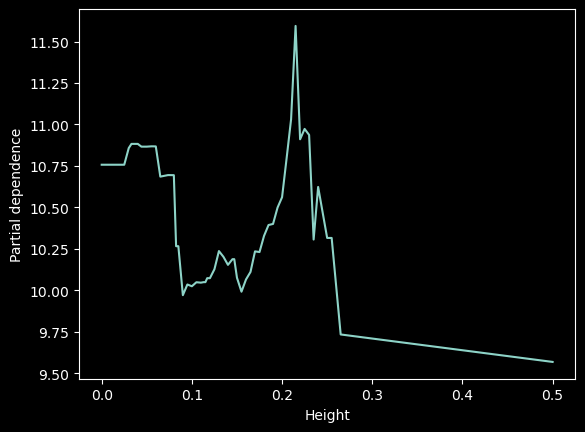

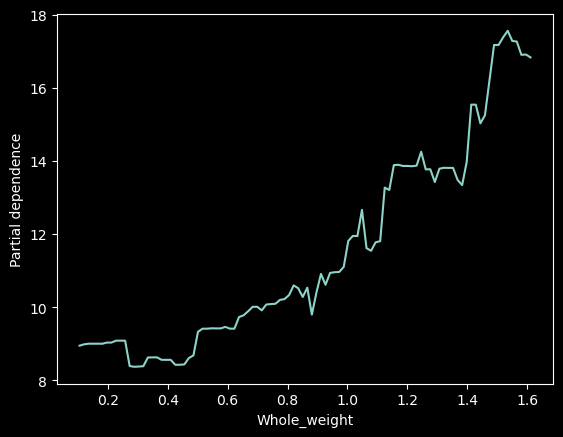

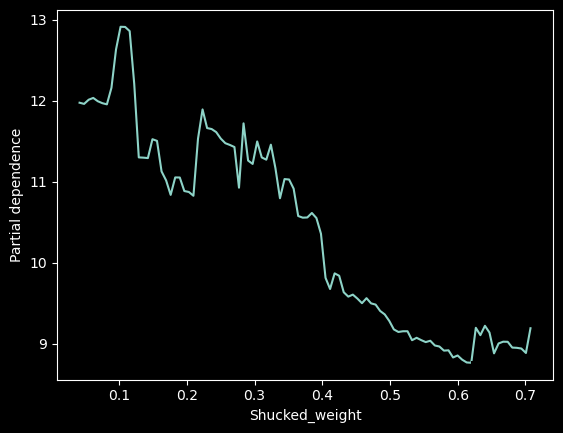

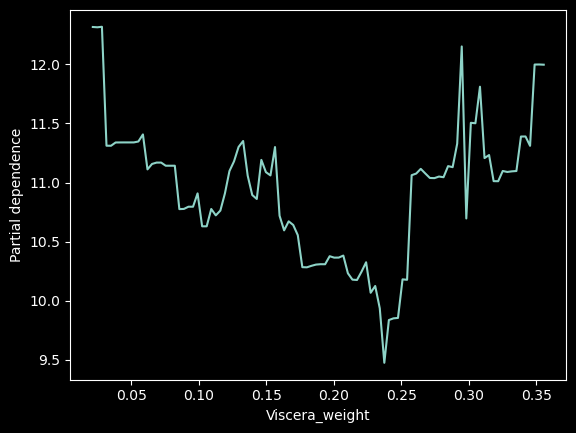

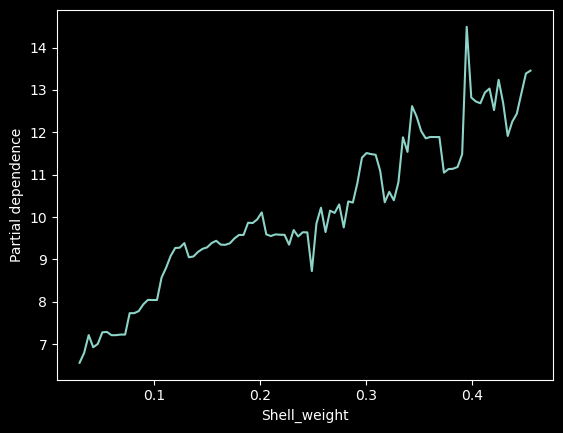

In [24]:
# Partial dependence plots
for col in feature_columns[:-3]:
    make_pdp(df=train_df, column=col)

Surprisingly, not all features still present positive correlation, when their values are being varied while keeping all others constant. It would indicate, that feature engineering shape ratios and weight ratios might give more information to the model

In [31]:
get_shap(df=train_df, row=100)

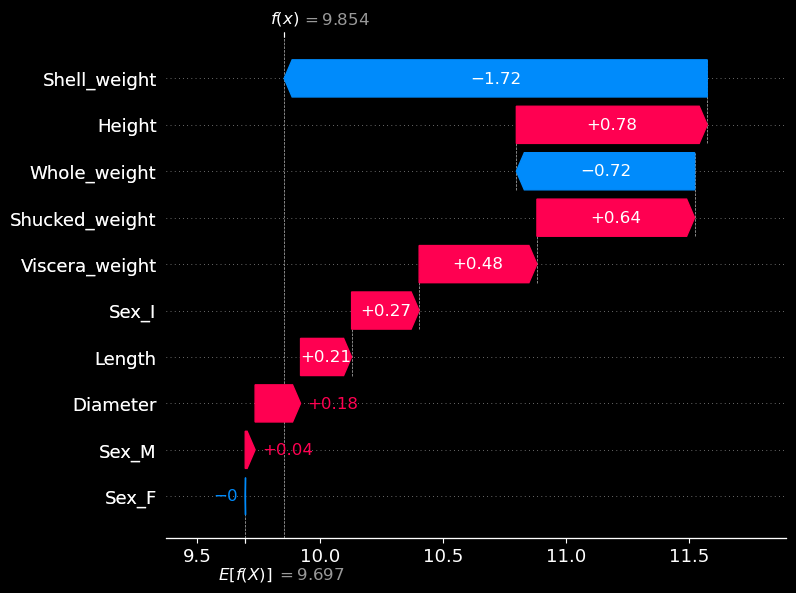

In [32]:
get_shap2(df=train_df, row=100)

In [25]:
pca, X_pca, loadings = apply_pca(train_df[feature_columns[:-3]]) # this is with outliers, might mess up standardization

In [26]:
loadings

PC1       PC2       PC3       PC4       PC5       PC6  \
Length          0.379105  0.379229 -0.459959 -0.119010  0.048699  0.056453   
Diameter        0.379860  0.379742 -0.407740 -0.175175  0.040198 -0.044698   
Height          0.368478  0.513917  0.601861  0.484532 -0.055385  0.005124   
Whole_weight    0.385297 -0.310228  0.054874 -0.033362 -0.086357 -0.859885   
Shucked_weight  0.375764 -0.447654 -0.263647  0.454735 -0.511858  0.343036   
Viscera_weight  0.379363 -0.364234  0.062209  0.111214  0.811936  0.217778   
Shell_weight    0.377678 -0.136267  0.428437 -0.707187 -0.253473  0.300475   

                     PC7  
Length         -0.693672  
Diameter        0.714807  
Height         -0.003344  
Whole_weight   -0.065733  
Shucked_weight  0.049415  
Viscera_weight  0.022599  
Shell_weight   -0.024188

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

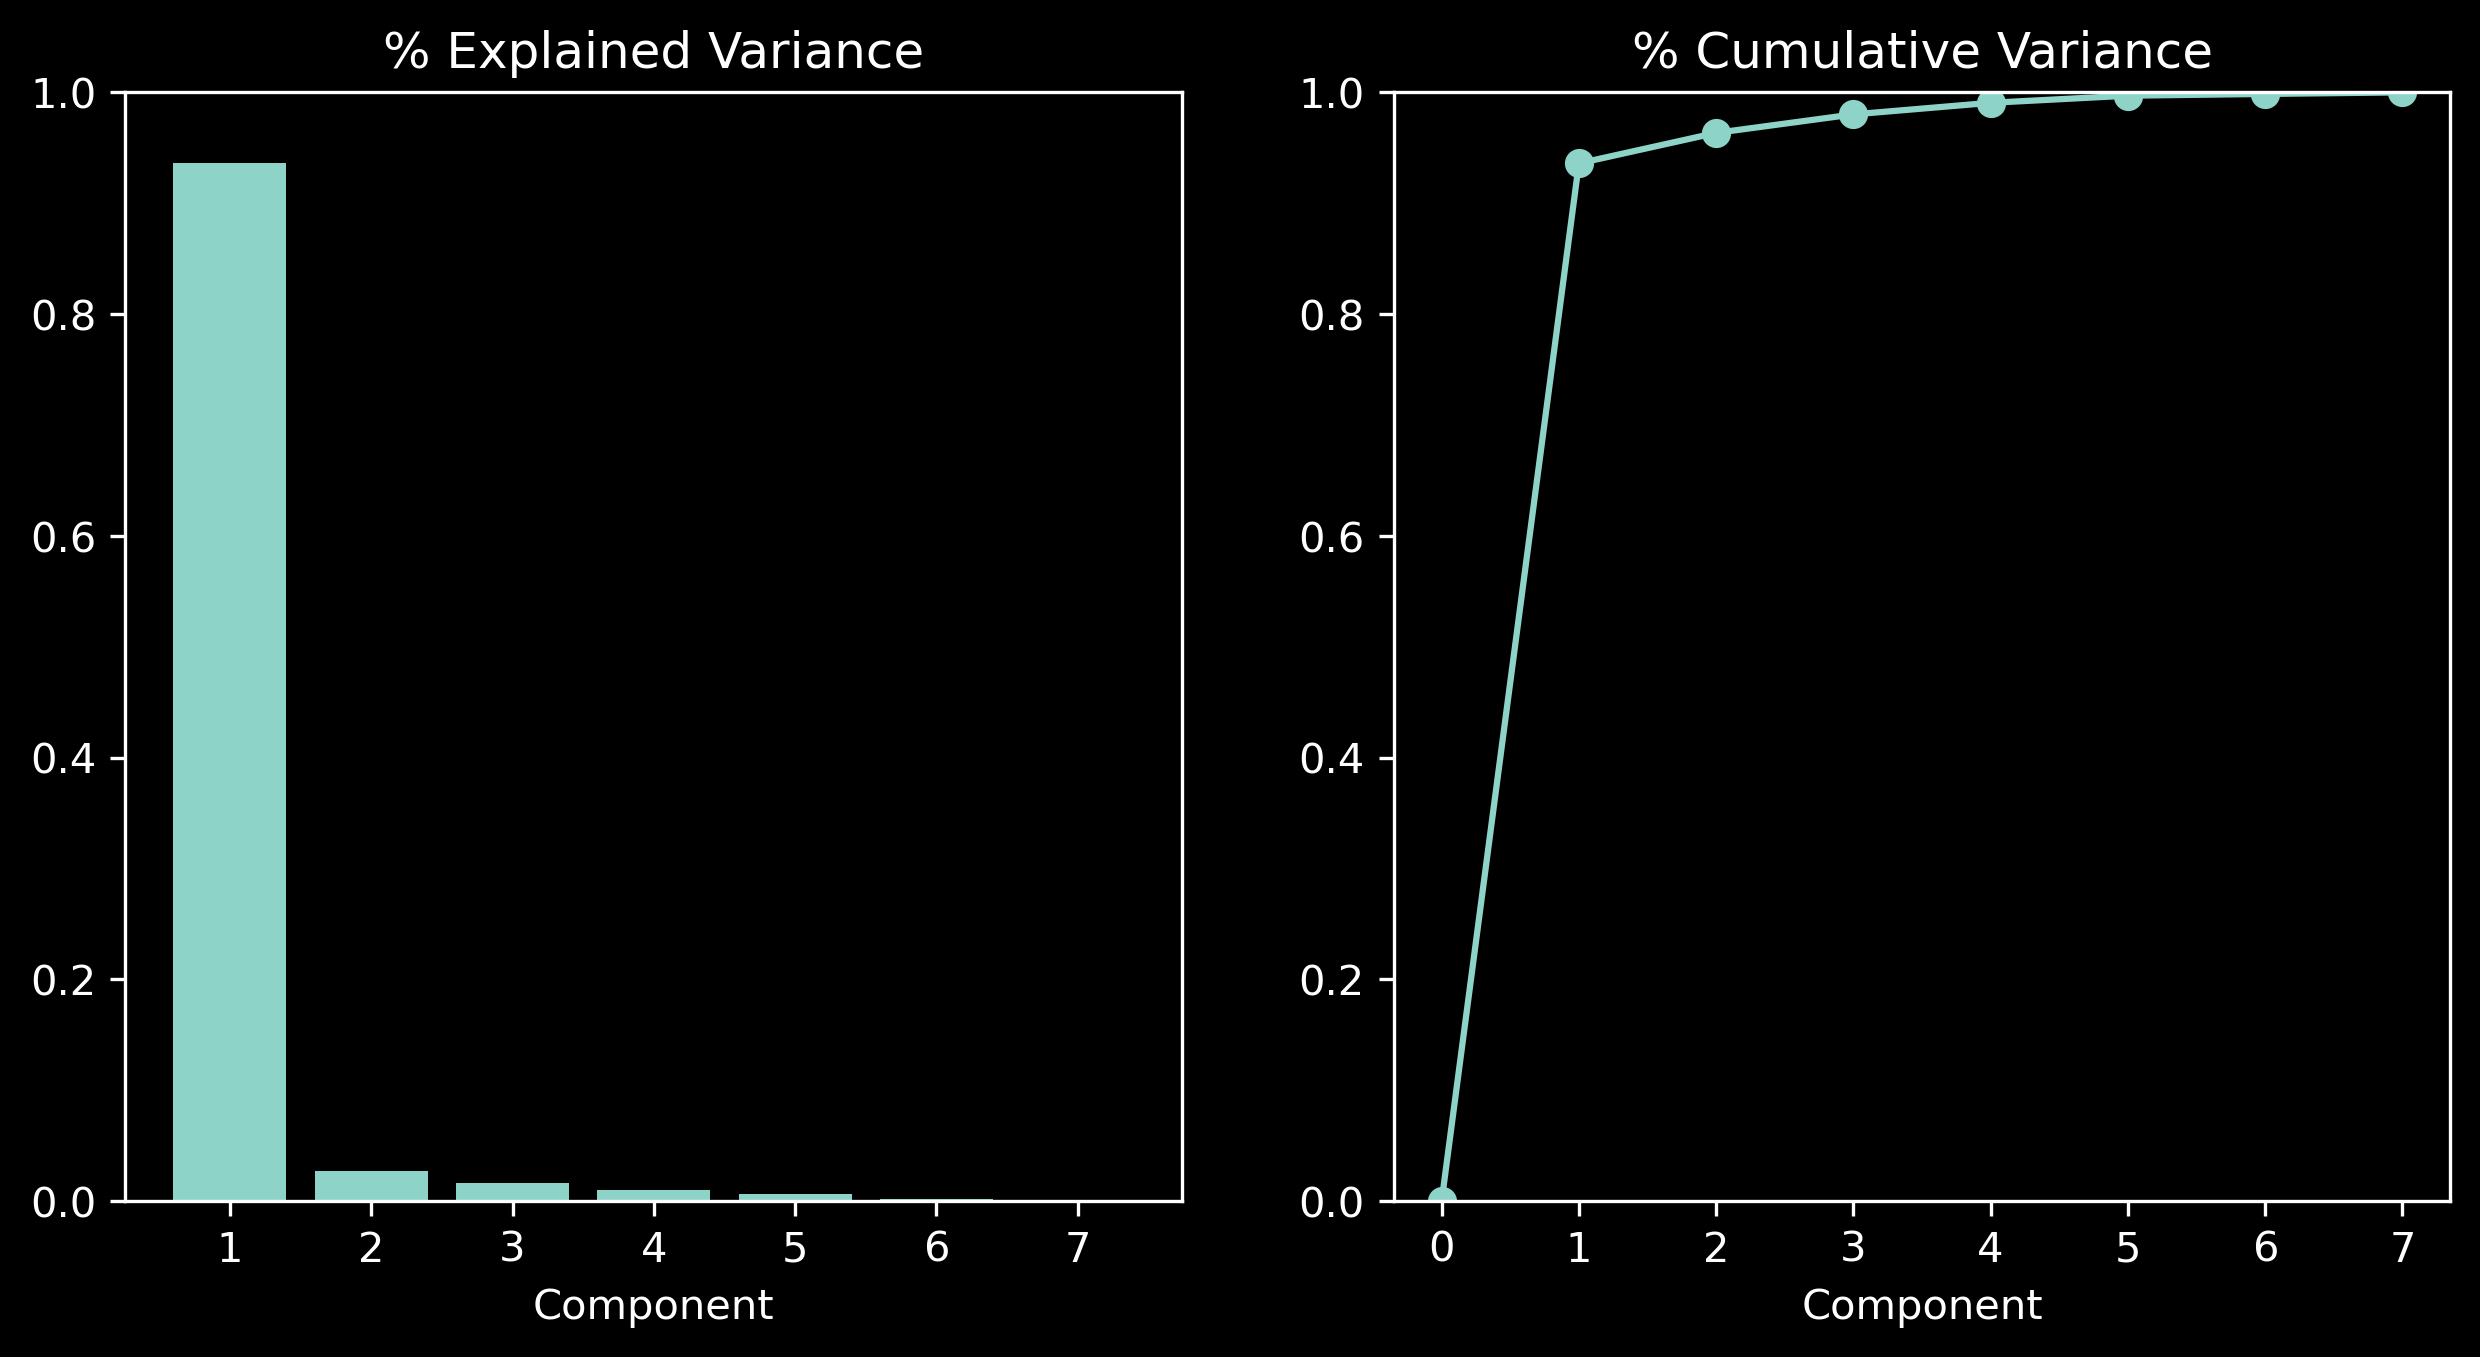

In [27]:
plot_variance(pca)

In [28]:
temp_df = pd.concat([train_df, X_pca[['PC1', 'PC2', 'PC3']]], axis=1)
temp_df.head()

Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   0.550     0.430   0.150        0.7715          0.3285          0.1465   
1   0.630     0.490   0.145        1.1300          0.4580          0.2765   
2   0.160     0.110   0.025        0.0210          0.0055          0.0030   
3   0.595     0.475   0.150        0.9145          0.3755          0.2055   
4   0.555     0.425   0.130        0.7820          0.3695          0.1600   

   Shell_weight  Rings  Sex_F  Sex_I  Sex_M       PC1       PC2       PC3  
0        0.2400     11      1      0      0  0.273583  0.518557  0.030372  
1        0.3200     11      1      0      0  1.974802 -0.139535 -0.390287  
2        0.0050      6      0      1      0 -5.875688 -1.682433  0.364261  
3        0.2500     10      0      0      1  1.049869  0.413958 -0.306085  
4        0.1975      9      0      1      0  0.088021  0.143649 -0.468136

In [29]:
make_mi(temp_df)

Shell_weight      0.675609
Whole_weight      0.578213
PC1               0.562156
Height            0.551684
Viscera_weight    0.544668
Diameter          0.542804
Length            0.530649
Shucked_weight    0.511685
Sex_I             0.238051
PC3               0.182756
PC2               0.175478
Sex_F             0.078925
Sex_M             0.060059
Name: MI Scores, dtype: float64

In [30]:
temp_df.drop(columns=['Length', 'Sex_F', 'Sex_M', 'PC2', 'Diameter', 'Height', 'Viscera_weight'], axis=1, inplace=True)
crossval(temp_df)

RMSLE mean  RMSLE std  Relative Improvement (%)
    0.151697   0.001373                  1.032014

XGBoost Regressor is not sensitive to multicollinearity, so score isn't better after using PCA

To consider: 
- Feature engineering based on pca loadings + some characteristic ratios
- Checking performance of other models (more sensitive ones) with and without PCA